In [1]:
import ot
import ternary

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr

from tqdm import trange
from ternary.helpers import project_sequence

from lib_jax.estimator_entropy import ent
from lib_jax.gd import mirror_descent
from lib_jax.mirror_langevin import mirror_langevin
from lib_jax.utils_plot import plot_trajectory
from lib_jax.mirror_maps import EntropicMirror, EuclideanMirror

### Target

Dirichlet distribution from [1] (https://github.com/vishwakftw/metropolis-adjusted-MLA/tree/main).

The goal is to sample from a distribution $\nu\propto \exp\big(-V(x)\big)$ with potential $V(x) = - \sum_{i=1}^d a_i \log(x_i) - a_{d+1} \log(1-\sum_{i=1}^d x_i)$, i.e. a Dirichlet distribution.

We will use the KL to learn it, i.e. $\mathcal{F}(\mu) = \int V\ \mathrm{d}\mu + \int \log (\mu(x))\ \mathrm{d}\mu(x)$. To stay on the (open) simplex $\Delta_d =\{x\in \mathbb{R}^{d+1}, x_i>0, \sum_{i=1}^{d+1} x_i < 1\}$, we can use a mirror map.

Here we use $\psi(x) = \sum_{i=1}^d x_i \log(x_i) + (1-\sum_i x_i) \log (1-\sum_i x_i)$ for which we have
\begin{align}
    & \nabla \psi(x) = \Big(\log x_i - \log(1-\sum_j x_j)\Big)_i \\
    & \nabla \psi^*(y) = \left(\frac{e^{y_i}}{1+\sum_j e^{y_j}}\right)_i.
\end{align}

The scheme here is given by
\begin{equation}
    T_{k+1} = \nabla \psi^*\circ (\nabla\psi - \gamma \nabla_{W_2}\mathcal{F}(\mu_k)),
\end{equation}
where $\nabla\mathcal{F}(\mu_k) = \nabla V + \nabla \log \mu_k$, with the density of $\mu_k$ estimated through a Kernel Density Estimator.

[1] Srinivasan, Vishwak, Andre Wibisono, and Ashia Wilson. "Fast sampling from constrained spaces using the Metropolis-adjusted Mirror Langevin Algorithm." arXiv preprint arXiv:2312.08823 (2023).

In [2]:
d = 2
alpha = np.full((d + 1,), 6.0) 

def V(x):    
    cpt1 = - jnp.sum(alpha[:-1] * jnp.log(x), axis=-1, keepdims=True)
    cpt2 = - alpha[-1] * jnp.log(jnp.clip(1-jnp.sum(x, axis=-1, keepdims=True), 1e-8))
    return cpt1 + cpt2

@jax.jit
def target(x):
    out = V(x) - ent(x)
    return jnp.mean(out)

@jax.jit
def grad_target_V(x):    
    return sum_V(x)

@jax.jit
def sum_V(x):
    return jnp.sum(V(x))

@jax.jit
def sum_kde(x):
    kde = jax.scipy.stats.gaussian_kde(x.T)
    logpdf = kde.logpdf(x.T)
    return jnp.sum(logpdf)

@jax.jit
def grad_target(x):    
    return sum_V(x) + sum_kde(x)

@jax.jit
def target_V(x):
    out = V(x)
    return jnp.mean(out)

target_grad = jax.jit(jax.grad(grad_target))
target_grad_V = jax.jit(jax.grad(grad_target_V))

### Mirror Descent

In [3]:
n_epochs = 201 # 1001
lr = 1e-3
n_particles = 100
d = 2

rng = jax.random.PRNGKey(0)
master_key, key = jax.random.split(rng, 2)


# initialise from [1/2d, 1/2d ....] +/- epsilon * [1/24d, 1/24d, ....]
x0 = np.full((n_particles, d), fill_value=1 / (2 * d))
x0 += jax.random.uniform(key, (n_particles, d)) / (12 * d) - 1 / (24 * d)

# x0 = np.random.rand(n_particles, d) / 2

mirror_euc = EuclideanMirror()
mirror = EntropicMirror()

particles_gd, grads_gd = mirror_descent(target_grad, n_epochs=n_epochs, lr=lr, mirror=mirror_euc, x0=x0)
particles_md, grads_md = mirror_descent(target_grad, n_epochs=n_epochs, lr=lr, mirror=mirror, x0=x0)
particles_mld, grads_mld = mirror_langevin(key, target_grad_V, n_epochs=n_epochs, lr=lr, mirror=mirror, x0=x0, bar=False)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


/home/clement/anaconda3/envs/py311/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


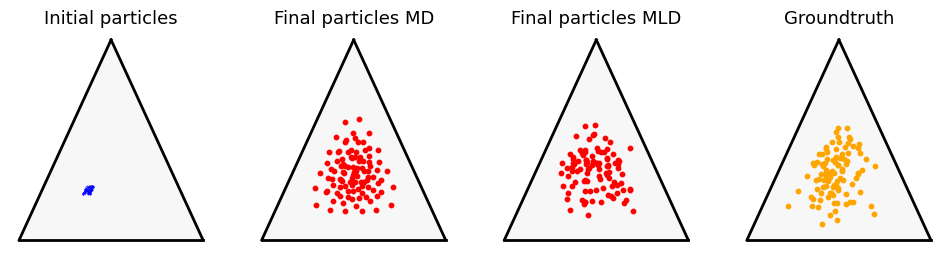

In [4]:
alpha_tgt = np.full((d + 1,), 6.0) 
x_target = np.random.dirichlet(alpha_tgt, size=100)

figure, ax = plt.subplots(1, 4, figsize=(12, 3))

# plt.gcf().subplots_adjust(wspace=0)

tax0 = ternary.TernaryAxesSubplot(ax=ax[0])
tax1 = ternary.TernaryAxesSubplot(ax=ax[1])
tax2 = ternary.TernaryAxesSubplot(ax=ax[2])
tax3 = ternary.TernaryAxesSubplot(ax=ax[3])


tax0.boundary(linewidth=2.0)
tax0.scatter(particles_md[0], color="blue", s=0.1)
tax0.set_title("Initial particles", fontsize=13)

tax1.boundary(linewidth=2.0)
tax1.scatter(particles_md[-1], color="red", s=10.0)
tax1.set_title("Final particles MD", fontsize=13)

tax2.boundary(linewidth=2.0)
tax2.scatter(particles_mld[-1], color="red", s=10.0)
tax2.set_title("Final particles MLD", fontsize=13)

tax3.boundary(linewidth=2.0)
tax3.scatter(x_target, color="orange", s=10.0)
tax3.set_title("Groundtruth", fontsize=13)

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")

# plt.savefig("./Figures/samples_dirichlet.pdf", format="pdf", bbox_inches="tight") #, dpi=150)

plt.show()

In [5]:
n_epochs = 201 # 1001
lr = 1e-3
n_particles = 100
d = 2

mirror_euc = EuclideanMirror()
mirror_ent = EntropicMirror()

ntry = 20

rng = jax.random.PRNGKey(0)
keys = jax.random.split(rng, ntry)

L_md = np.zeros((ntry, n_epochs))
L_mld = np.zeros((ntry, n_epochs))


for i, key in enumerate(keys):    
    # initialise from [1/2d, 1/2d ....] +/- epsilon * [1/24d, 1/24d, ....]
    x0 = np.full((n_particles, d), fill_value=1 / (2 * d))
    x0 += jax.random.uniform(key, (n_particles, d)) / (12 * d) - 1 / (24 * d)
    
    # particles_gd, grads_gd = mirror_descent(target_grad, n_epochs=n_epochs, lr=lr, mirror=mirror_euc, x0=x0)
    particles_md, grads_md = mirror_descent(target_grad, n_epochs=n_epochs, lr=lr, mirror=mirror_ent, x0=x0)
    particles_mld, grads_mld = mirror_langevin(key, target_grad_V, n_epochs=n_epochs, lr=lr, mirror=mirror_ent, x0=x0, bar=False)
    
    for k in range(n_epochs):
        L_md[i, k] = target(particles_md[k])
        L_mld[i, k] = target(particles_mld[k])

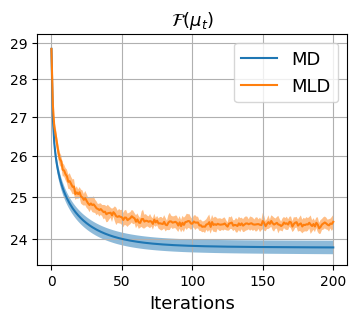

In [6]:
mean_md = np.mean(L_md, axis=0)
std_md = np.std(L_md, axis=0)

mean_mld = np.mean(L_mld, axis=0)
std_mld = np.std(L_mld, axis=0)

fig, ax = plt.subplots(1, figsize=(4, 3))
# plt.gcf().subplots_adjust(top=1)

# plt.plot(np.array(L_gd), label="GD")
ax.plot(mean_md, label="MD")
ax.fill_between(list(range(n_epochs)), mean_md - std_md, mean_md + std_md, alpha=0.5)
ax.plot(mean_mld, label="MLD")
ax.fill_between(list(range(n_epochs)), mean_mld - std_mld, mean_mld + std_mld, alpha=0.5)

ax.set_yscale("log")
# plt.xscale("log")

# ax.set_ylabel(r"$\mathcal{F}(\mu_t)$", fontsize=13) #, rotation=0)
ax.set_xlabel("Iterations", fontsize=13)
ax.set_yticks([2.4e1, 2.5e1, 2.6e1, 2.7e1, 2.8e1, 2.9e1])
ax.set_yticklabels([24, 25, 26, 27, 28, 29])

plt.legend(fontsize=13)
plt.grid(True)

plt.title(r"$\mathcal{F}(\mu_t)$", fontsize=13)

# plt.savefig("./Figures/KL_dirichlet.pdf", format="pdf", bbox_inches="tight") #, dpi=150)
plt.show()